# Initialize environment

In [1]:
using Pkg
Pkg.activate("..")

using Printf, Statistics,
        JLD2, FileIO, Interpolations, PyPlot, PyPlotPlus, DataStructures,
        SqueezeDispersion.Samoan

using LinearAlgebra: norm

usecmbright() # for plotting

# Load data

In [2]:
datapath = joinpath("..", "data", "samoanpassagedata.jld2")
ctd = load(datapath, "ctd")
vmp = load(datapath, "vmp")

# Sort vmp data from south to north
vmpbylat = OrderedDict{Float64,Any}()
for (name, profile) in vmp
    profile["name"] = name
    vmpbylat[profile["lat"]] = profile
end

sort!(vmpbylat)
vmp = OrderedDict{String,Any}()
for profile in values(vmpbylat)
    vmp[profile["name"]] = profile
end

ctdlon = ctd["lon"]
ctdlat = ctd["lat"]
ctdsigma = ctd["sigma4"]
ctddepth = ctd["depth"]

nz, nctd = size(ctdsigma)
nvmp = length(vmp)
println("CTD data size: ndepth = $nz, nctd = $nctd, nvmp = $nvmp\n")

println("VMP profiles:\n")
for (name, profile) in vmp
    z, ep, sig = unpack_vmp_profile(profile)
    lat = profile["lat"]
    lon = profile["lon"]
    
    @printf("% 13s (%.2f N, %.2f W) | z: (%d, %d) meters, σ₄: (%.5f, %.5f) kg/m³\n", 
        profile["name"], lat, lon, z[1], z[end], nanmaximum(sig), nanminimum(sig))
    
end

CTD data size: ndepth = 6001, nctd = 18, nvmp = 13

VMP profiles:

 SP1_Line9_02 (-9.83 N, -169.31 W) | z: (-5303, -3442) meters, σ₄: (45.97834, 45.85083) kg/m³
 SP1_Line9_04 (-9.48 N, -169.02 W) | z: (-5234, -3442) meters, σ₄: (45.97827, 45.85180) kg/m³
 SP1_Line9_06 (-9.14 N, -168.98 W) | z: (-5122, -3442) meters, σ₄: (45.97770, 45.85166) kg/m³
 SP1_Line9_07 (-9.04 N, -168.96 W) | z: (-4962, -3442) meters, σ₄: (45.97797, 45.85172) kg/m³
 SP1_Line9_08 (-8.99 N, -168.96 W) | z: (-4691, -3442) meters, σ₄: (45.97777, 45.84898) kg/m³
 SP1_Line9_09 (-8.90 N, -168.90 W) | z: (-4990, -3442) meters, σ₄: (45.97545, 45.84830) kg/m³
SP1_Line9_102 (-8.81 N, -168.76 W) | z: (-4977, -3442) meters, σ₄: (45.97648, 45.84982) kg/m³
SP1_Line9_112 (-8.61 N, -168.73 W) | z: (-5079, -3442) meters, σ₄: (45.97665, 45.85238) kg/m³
 SP1_Line9_13 (-8.31 N, -168.66 W) | z: (-5052, -3442) meters, σ₄: (45.97589, 45.85161) kg/m³
 SP1_Line9_14 (-8.24 N, -168.69 W) | z: (-4932, -3442) meters, σ₄: (45.97543, 45.85482)

In [3]:
function compileoverturns(vmp; davg=nothing)

    overturns = Dict{Symbol,Array{Float64,1}}()
       overturns[:z] = Array{Float64,1}()
     overturns[:sig] = Array{Float64,1}()
      overturns[:dz] = Array{Float64,1}()
    overturns[:dsig] = Array{Float64,1}()

    for name in keys(vmp)
        z, ep, sig = unpack_vmp_profile(vmp[name])
        
        if davg != nothing
            sig = movingavg(sig, davg)
        end
        
        z_ov, sig_ov, z_delta, sig_delta = getoverturns(z, sig)
        
        append!(overturns[:z], z_ov)
        append!(overturns[:sig], sig_ov)    
        append!(overturns[:dz], z_delta) 
        append!(overturns[:dsig], sig_delta)
    end
    
    overturns
end

compileoverturns (generic function with 1 method)

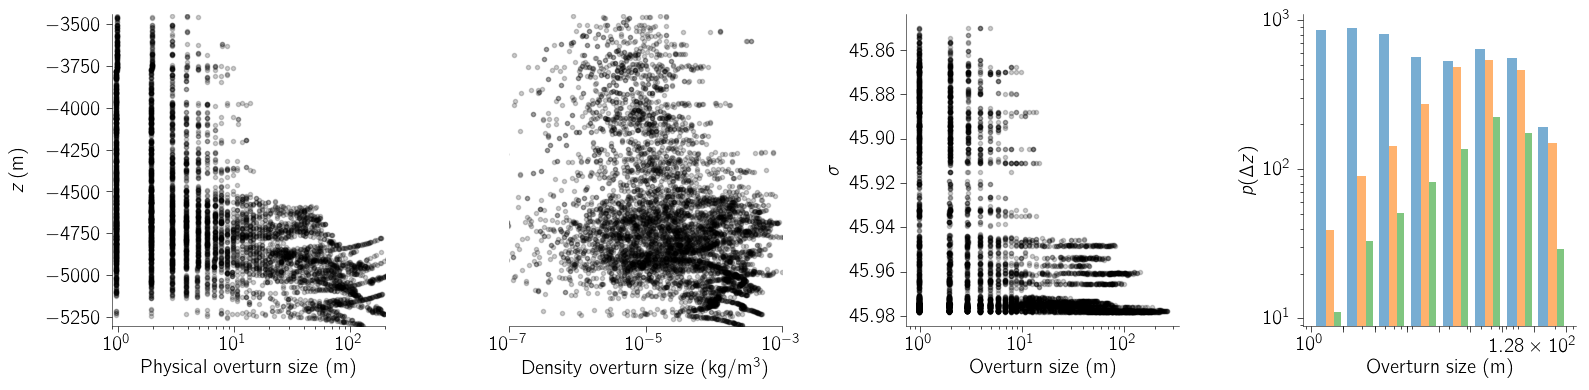

In [4]:
zlims = (-5305, -3442)
zdeltalims = (0.9, 200)
sigdeltalims = (1e-7, 1e-3)

overturns0 = compileoverturns(vmp)
overturns1 = compileoverturns(vmp, davg=20)
overturns2 = compileoverturns(vmp, davg=100)

fig, axs = subplots(ncols=4, figsize=(16, 4))
    
sca(axs[1])
xlabel("Physical overturn size (m)")
ylabel(L"z \, \mathrm{(m)}", labelpad=12.0)

cornerspines()
xscale("log")
xlim(zdeltalims)
ylim(zlims)

#text(name, 100, zlims[1])

plot(overturns0[:dz], overturns0[:z], "k.", alpha=0.2)

sca(axs[2])
xlabel("Density overturn size \$ \\mathrm{(kg/m^3)} \$")
bottomspine()
xscale("log")
axs[2][:tick_params](left=false, labelleft=false)
xlim(sigdeltalims)
ylim(zlims)

plot(overturns0[:dsig], overturns0[:z], "k.", alpha=0.2)

sca(axs[3])
xlabel("Overturn size (m)")
ylabel(L"\sigma")
xscale("log")
#yscale("log")
invertaxis()
cornerspines()

plot(overturns0[:dz], overturns0[:sig], "k.", alpha=0.2)

sca(axs[4])
xlabel("Overturn size (m)")
ylabel(L"p(\Delta z)")
cornerspines()
xscale("log")
yscale("log")

#axs[4][:hist](overturns0[:dz], alpha=0.4, bins=20)
#axs[4][:hist](overturns1[:dz], alpha=0.2, bins=20)
#axs[4][:hist](overturns2[:dz], alpha=0.4, bins=20)

bins = [1, 2, 4, 8, 16, 32, 64, 128, 256]
axs[4][:hist]([overturns0[:dz], overturns1[:dz], overturns2[:dz]], bins, alpha=0.6)
xticks(bins)

tightshow()

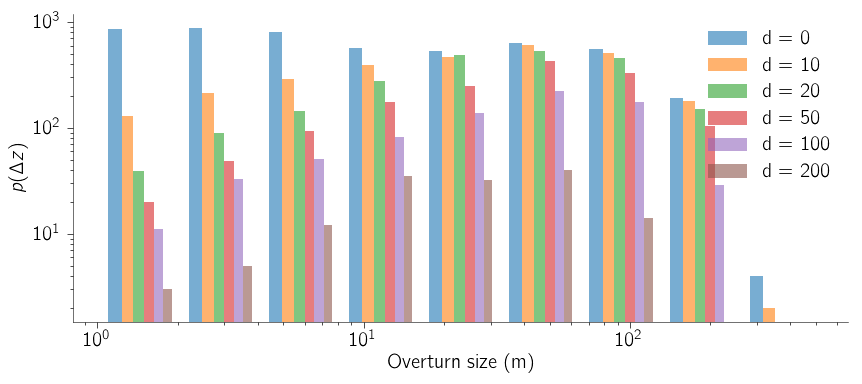

PyObject <matplotlib.legend.Legend object at 0x1499829e8>

In [5]:
overturns = [compileoverturns(vmp)]
davgs = [10, 20, 50, 100, 200]

for d in davgs
    append!(overturns, [compileoverturns(vmp, davg=d)])
end

fig, ax = subplots(figsize=(10, 4))
xlabel("Overturn size (m)")
ylabel(L"p(\Delta z)")
cornerspines()
xscale("log")
yscale("log")

#axs[4][:hist](overturns0[:dz], alpha=0.4, bins=20)
#axs[4][:hist](overturns1[:dz], alpha=0.2, bins=20)
#axs[4][:hist](overturns2[:dz], alpha=0.4, bins=20)

bins = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
ax[:hist](map(x->x[:dz], overturns), bins, alpha=0.6, label=map(x-> "d = $x", cat([0], davgs, dims=1)))
legend()

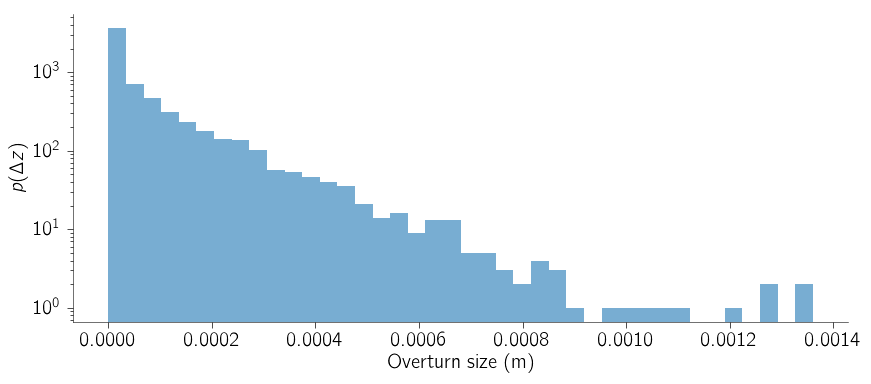

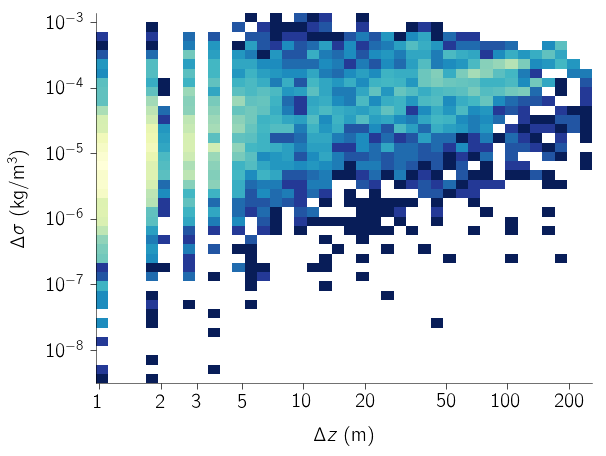

maximum(overturns[:dsig]) = 0.00136092996399384


No handles with labels found to put in legend.


0.00136092996399384

In [16]:
using Statistics, PyCall

@pyimport matplotlib.colors as clrs

overturns = compileoverturns(vmp)

dzs = [1, 2, 3, 5, 10, 20, 50, 100, 200]
dsigs = 10.0 .^ (-8:-3)

fig, ax = subplots(figsize=(10, 4))
xlabel("Overturn size (m)")
ylabel(L"p(\Delta z)")
cornerspines()
#xscale("log")
yscale("log")

#bins = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
ax[:hist](overturns[:dsig], bins=40, alpha=0.6)
legend()

fig, ax = subplots()
xlabel(L"\Delta z \,\, \mathrm{(m)}"; labelpad=12.0)
ylabel(L"\Delta \sigma \,\, \mathrm{(kg/m^3)}"; labelpad=12.0)

xticks(log.(10, dzs), map(x->"$x", dzs))
yticks(log.(10, dsigs), map(x->@sprintf("\$10^{%d}\$", log(10, x)), dsigs))

cornerspines()

ax[:hist2d](log.(10, overturns[:dz]), log.(10, overturns[:dsig]), bins=40, norm=clrs.LogNorm())

@show maximum(overturns[:dsig])

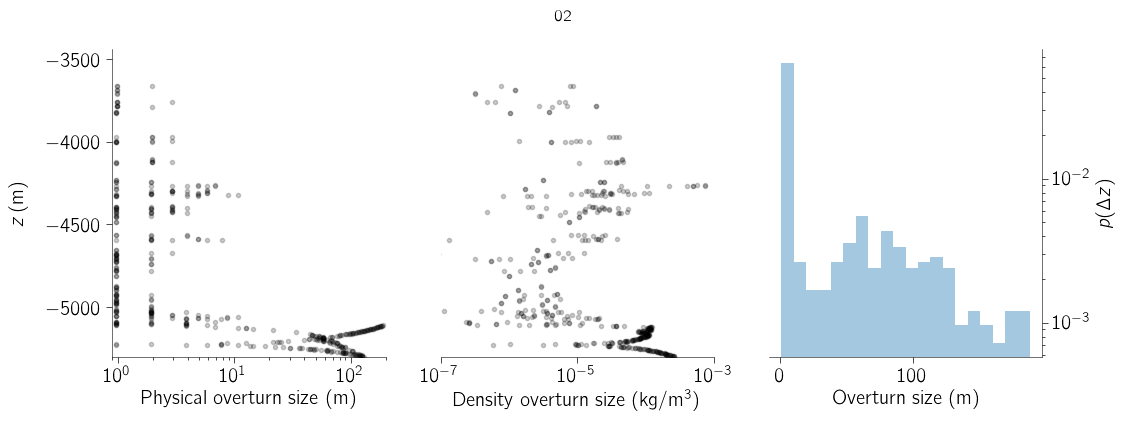

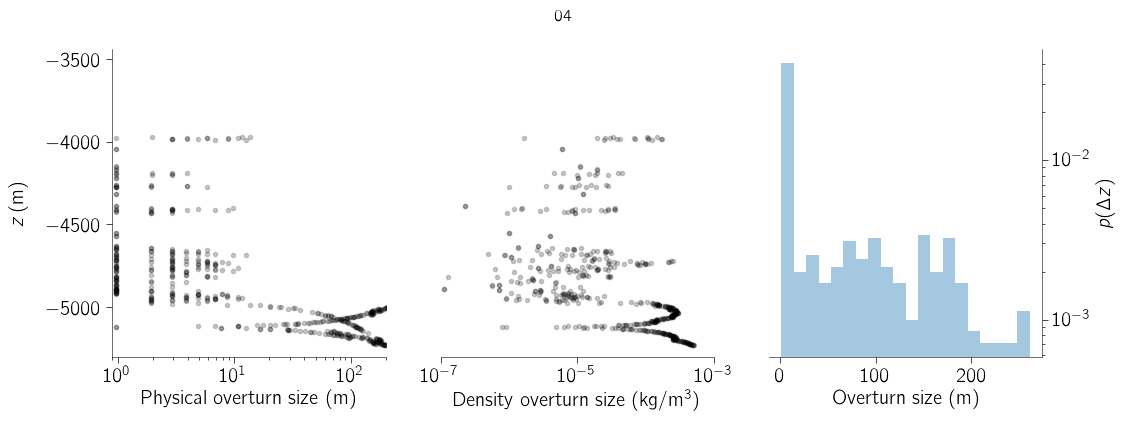

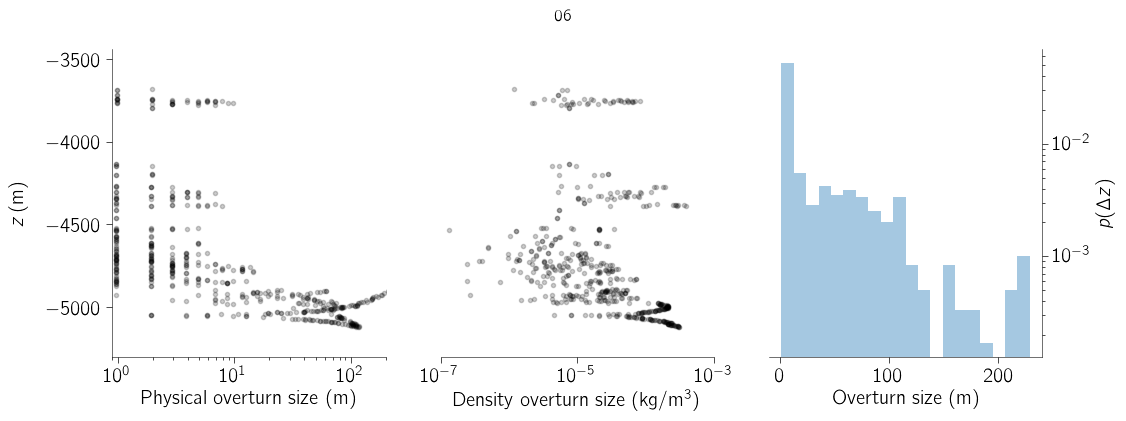

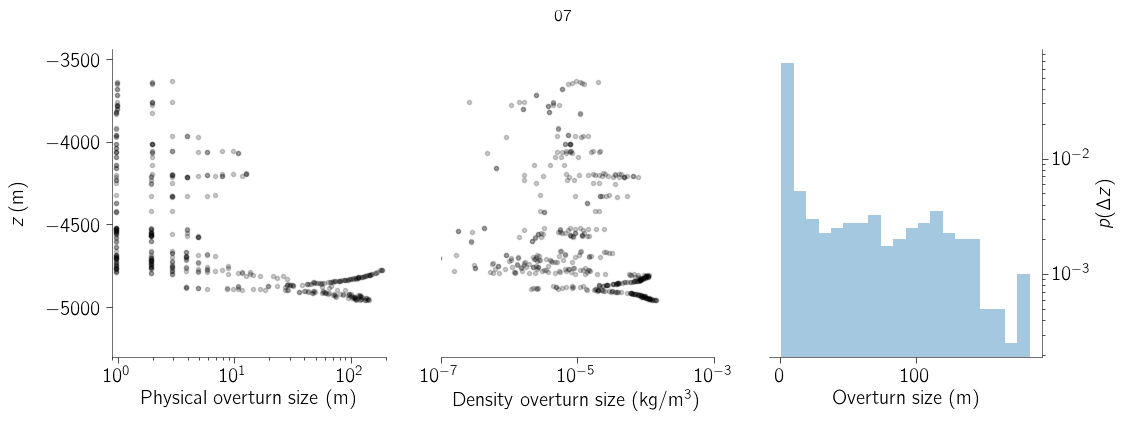

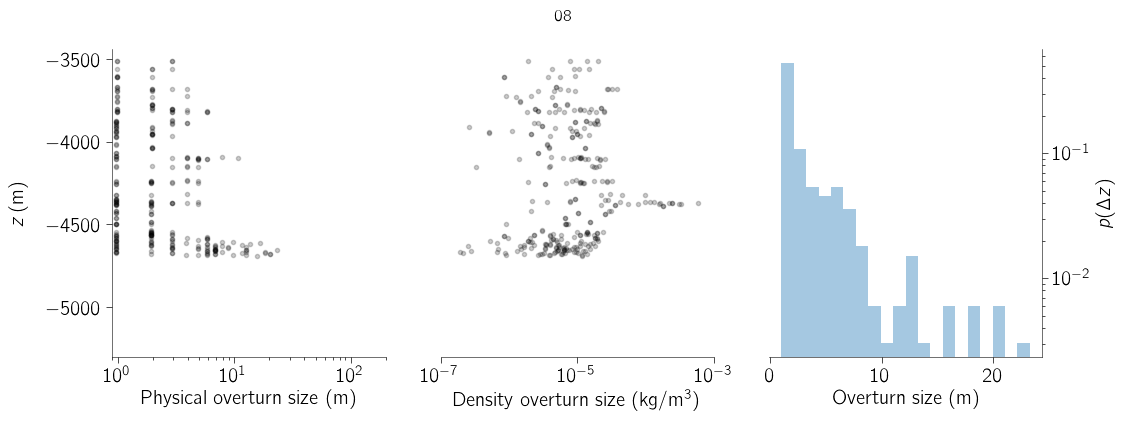

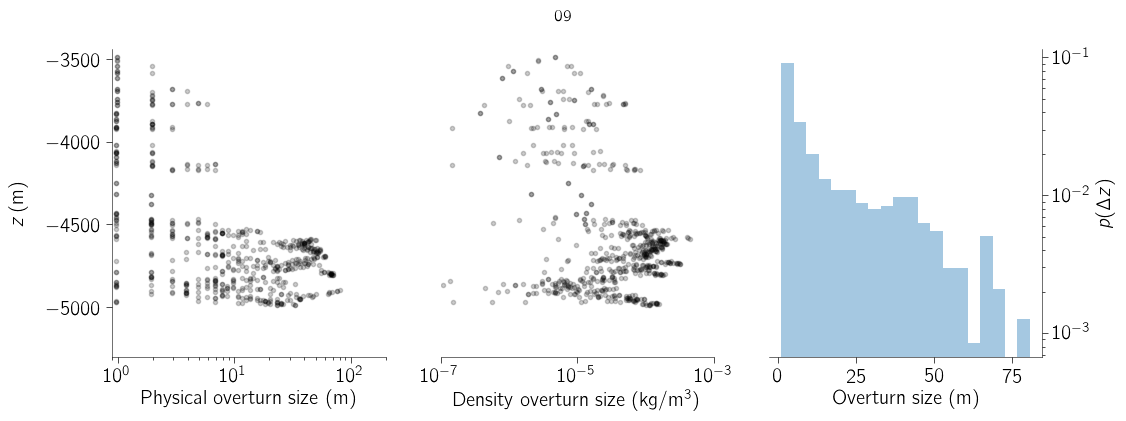

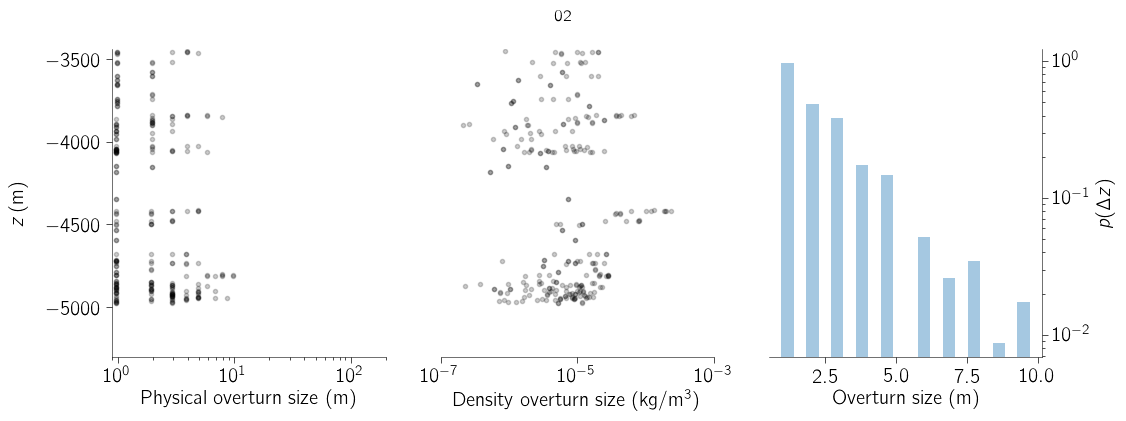

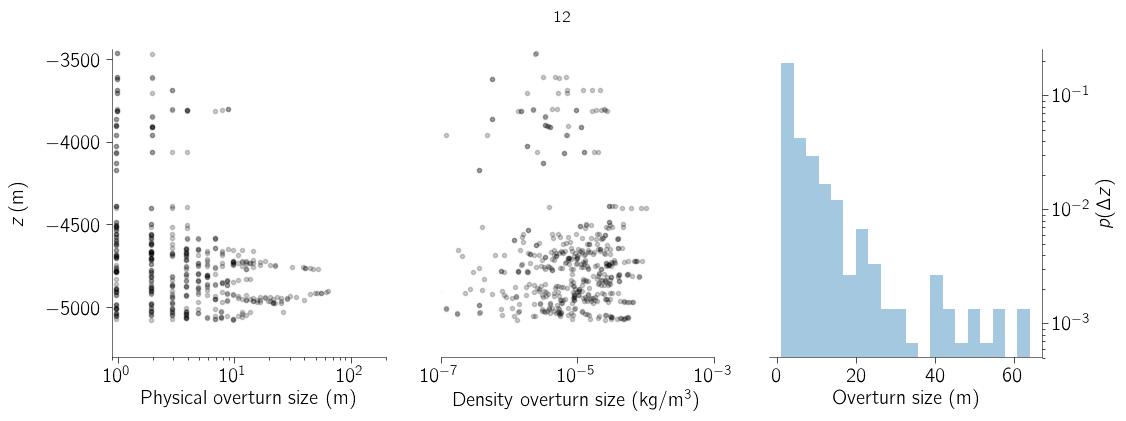

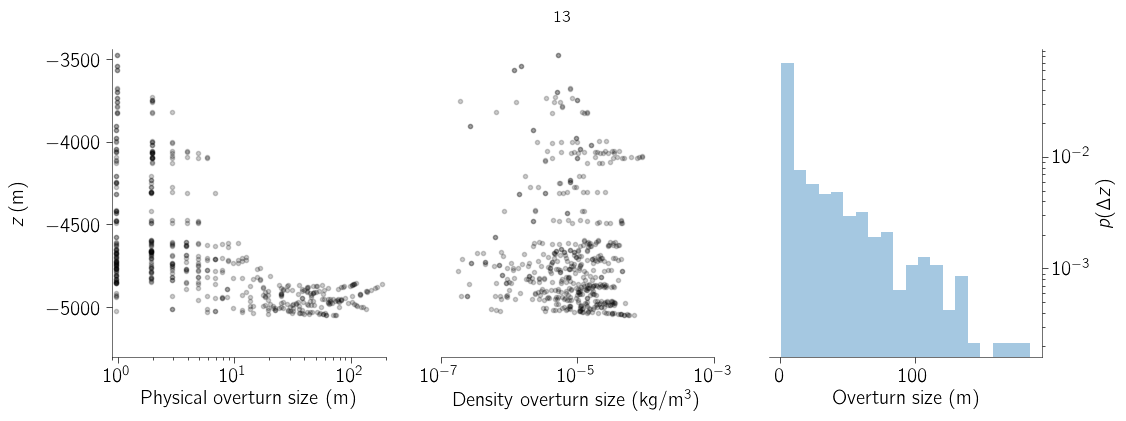

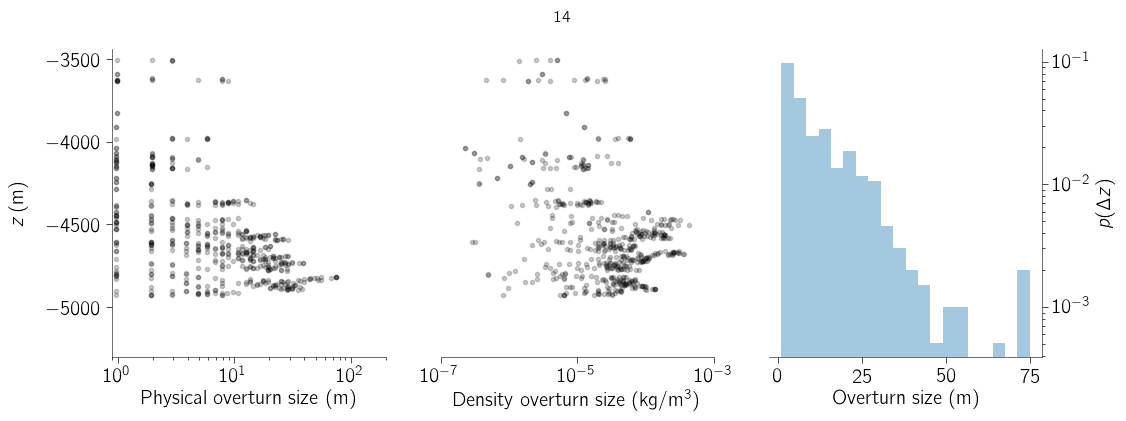

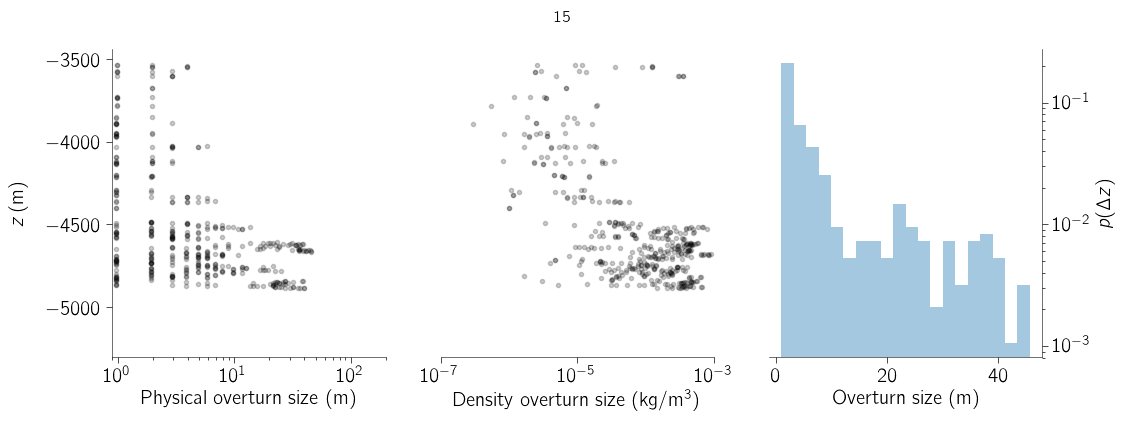

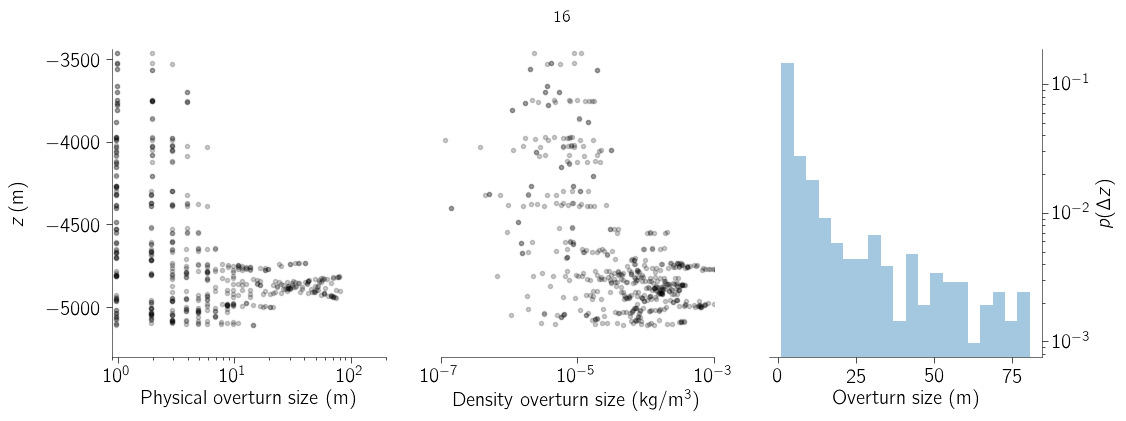

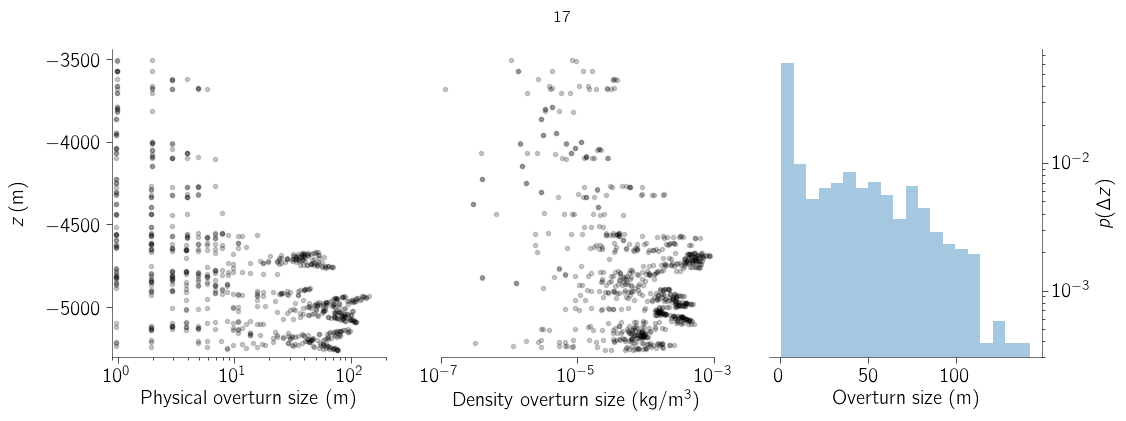

In [7]:
zlims = (-5305, -3442)
zdeltalims = (0.9, 200)
sigdeltalims = (1e-7, 1e-3)

for name in keys(vmp)
    z, ep, sig = unpack_vmp_profile(vmp[name])
    z_ov, sig_ov, z_delta, sig_delta = getoverturns(z, sig)

    fig, axs = subplots(ncols=3, figsize=(12, 4))
    
    fig[:suptitle](@sprintf("%s", name[end-1:end]))

    sca(axs[1])
    xlabel("Physical overturn size (m)")
    ylabel(L"z \, \mathrm{(m)}", labelpad=12.0)

    cornerspines()
    xscale("log")
    xlim(zdeltalims)
    ylim(zlims)
    
    #text(name, 100, zlims[1])

    plot(z_delta, z_ov, "k.", alpha=0.2)

    sca(axs[2])
    xlabel("Density overturn size \$ \\mathrm{(kg/m^3)} \$")
    bottomspine()
    xscale("log")
    axs[2][:tick_params](left=false, labelleft=false)
    xlim(sigdeltalims)
    ylim(zlims)

    plot(sig_delta, z_ov, "k.", alpha=0.2)

    sca(axs[3])
    xlabel("Overturn size (m)")
    ylabel(L"p(\Delta z)")
    cornerspines(side="right")
    axisright()
    #xscale("log")
    yscale("log")

    axs[3][:hist](z_delta, alpha=0.4, normed=1, bins=20)
    #axs[3][:hist](filter(x->x>2, z_delta), alpha=0.4, normed=1, bins=20);
end

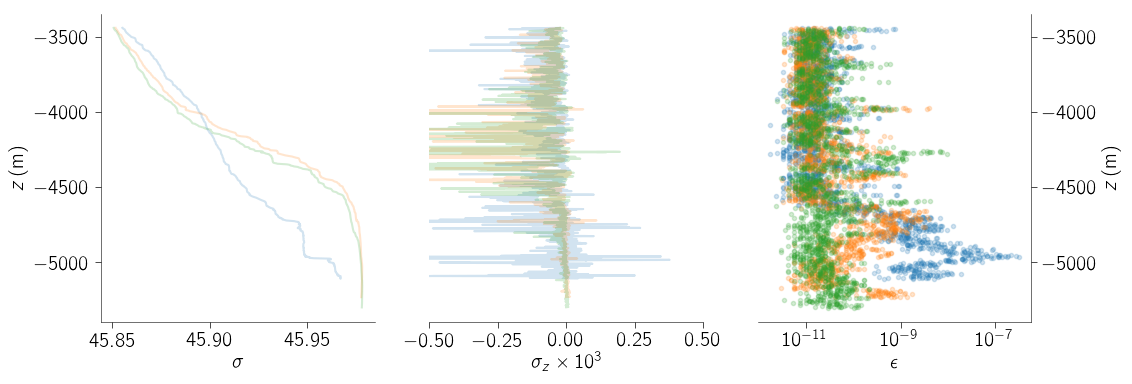

keys(vmp) = ["SP1_Line9_02", "SP1_Line9_04", "SP1_Line9_06", "SP1_Line9_07", "SP1_Line9_08", "SP1_Line9_09", "SP1_Line9_102", "SP1_Line9_112", "SP1_Line9_13", "SP1_Line9_14", "SP1_Line9_15", "SP1_Line9_16", "SP1_Line9_17"]


In [8]:
@show keys(vmp)
profiles = ["SP1_Line9_16", "SP1_Line9_04", "SP1_Line9_02"]

fig, axs = subplots(ncols=3, sharey=true, figsize=(12, 4))

for p in profiles
    
    z = reverse(-vmp[p]["depth"])
    ep = reverse(vmp[p]["epsilon"])
    sig = reverse(vmp[p]["sgth4"])
    
    sigz = dz(sig, z)
    
    sca(axs[1])
    xlabel(L"\sigma")
    ylabel(L"z \, \mathrm{(m)}")
    cornerspines()
    
    plot(sig, z, alpha=0.2, label=p)
    
    sca(axs[2])
    xlabel(L"\sigma_z \times 10^3")
    bottomspine()
    axs[2][:tick_params](left=false)
    
    plot(sigz*1e3, z, alpha=0.2, label=p)
    
    sca(axs[3])
    xlabel(L"\epsilon")
    ylabel(L"z \, \mathrm{(m)}")
    cornerspines(side="right")
    axisright()
    
    plot(ep, z, alpha=0.2, linestyle="None", marker=".", label=p)
end

sca(axs[2])
xlim([-1, 1]*5e-1)

sca(axs[3])
xscale("log")
#legend()

#sca(axs[2])
#legend()

typeof(sigz) = Array{Float64,1}


┌ Info: Recompiling stale cache file /Users/gregorywagner/.julia/compiled/v1.0/StatsBase/EZjIG.ji for StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91]
└ @ Base loading.jl:1187


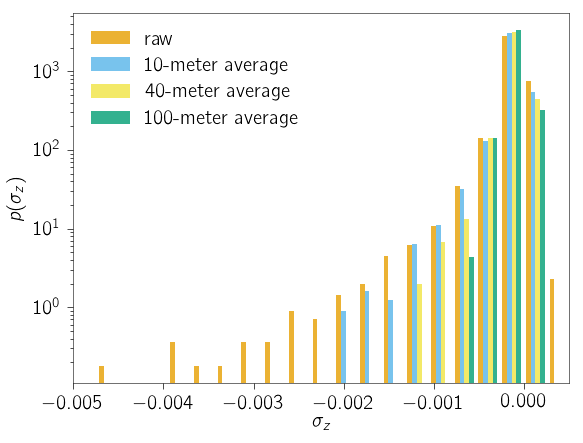

summarystats(sigz) = Summary Stats:
Mean:           -0.000077
Minimum:        -0.004739
1st Quartile:   -0.000088
Median:         -0.000037
3rd Quartile:   -0.000010
Maximum:        0.000520

summarystats(sigz_avg10) = Summary Stats:
Mean:           -0.000077
Minimum:        -0.001958
1st Quartile:   -0.000090
Median:         -0.000047
3rd Quartile:   -0.000016
Maximum:        0.000144

summarystats(sigz_avg40) = Summary Stats:
Mean:           -0.000078
Minimum:        -0.001162
1st Quartile:   -0.000089
Median:         -0.000056
3rd Quartile:   -0.000027
Maximum:        0.000024

summarystats(sigz_avg100) = Summary Stats:
Mean:           -0.000079
Minimum:        -0.000582
1st Quartile:   -0.000089
Median:         -0.000060
3rd Quartile:   -0.000036
Maximum:        0.000006



In [9]:
p = "SP1_Line9_04"

profiles = ["SP1_Line9_16", "SP1_Line9_04", "SP1_Line9_02"]
colors = ["#E69F00", "#56B4E9", "#F0E442", "#009E73"] #', '#D55E00']
labels = ["raw", "10-meter average", "40-meter average", "100-meter average"]

sigz = Array{Float64,1}()
sigz_avg10 = Array{Float64,1}()
sigz_avg40 = Array{Float64,1}()
sigz_avg100 = Array{Float64,1}()

for p in keys(vmp)
    z = reverse(-vmp[p]["depth"])
    ep = reverse(vmp[p]["epsilon"])
    sig = reverse(vmp[p]["sgth4"])
    
    psigz = dz(sig, z)
    append!(sigz, filter(!isnan, psigz))
    append!(sigz_avg10, filter(!isnan, movingavg(psigz, 10)))
    append!(sigz_avg40, filter(!isnan, movingavg(psigz, 40)))
    append!(sigz_avg100, filter(!isnan, movingavg(psigz, 100)))
end

fig, ax = subplots()

ax[:hist]([sigz, sigz_avg10, sigz_avg40, sigz_avg100], bins=20, alpha=0.8, normed=true, color=colors, label=labels)

@show typeof(sigz)

using StatsBase

@show summarystats(sigz)
@show summarystats(sigz_avg10)
@show summarystats(sigz_avg40)
@show summarystats(sigz_avg100)


xlabel(L"\sigma_z")
ylabel(L"p(\sigma_z)")
legend()
yscale("log")
xlim(-0.005, 0.0005);